<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/Soccer_PHImax_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPUTE PHImax time series FOR 3 SOCCER PLAYERS**

**1. Import Data**

In [1]:
import numpy as np
from google.colab import files
import numpy as np

# Create an upload button in the notebook
uploaded = files.upload()

# Assuming you upload only one file, get the filename
filename = next(iter(uploaded.keys()))

# Load the .npz file (I used: 'Data_timeseries_Alex.npz')
data = np.load(filename)

# Accessing data
# If you know the key, you can directly access the data
# For example, if the key is 'arr_0':
time_series_data = data['arr_0']

Saving Data_timeseries_Alex.npz to Data_timeseries_Alex.npz


quick look to double check

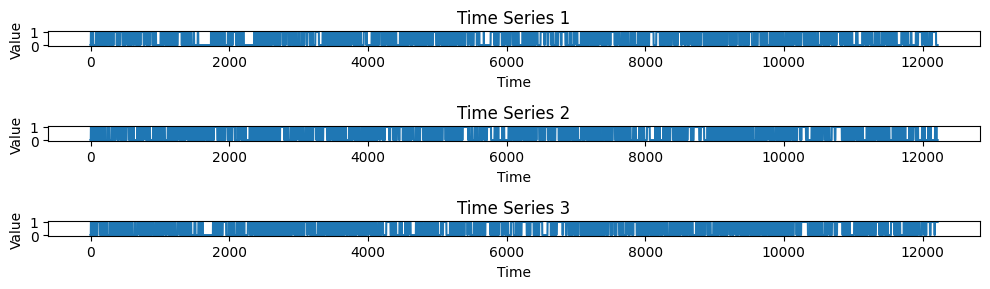

In [2]:
import matplotlib.pyplot as plt

# Assuming time_series_data is your loaded data with shape (3, N)
# where N is the number of time points

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 3))

# Titles for each subplot
titles = ['Time Series 1', 'Time Series 2', 'Time Series 3']

# Plot each time series in a separate subplot
for i in range(3):
    axs[i].plot(time_series_data[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Compute TPM time series in a MOVING AVERAGE fashion** *THIS CODE WILL WORK FOR ANY NUMBER OF PLAYERS AND RETURN IN LITTLE ENDIAN*

In [3]:
from itertools import product
import numpy as np

def compute_tpm_for_window(window_data):
    # Infer the number of states from the data
    num_states = int(np.max(window_data) + 1)

    # Number of players
    num_players = window_data.shape[0]

    # Total number of possible states
    total_states = num_states ** num_players

    # Initialize TPM with zeros
    TPM = np.zeros((total_states, total_states))

    # Generate the correct order of states
    all_states = list(product(range(num_states), repeat=num_players))
    correct_order = sorted(all_states, key=lambda x: (sum(x), x[::-1]))
    state_to_index = {state: index for index, state in enumerate(correct_order)}

    # Count transitions
    for t in range(window_data.shape[1] - 1):
        current_state = tuple(window_data[:, t])
        next_state = tuple(window_data[:, t + 1])
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        TPM[current_index, next_index] += 1

    # Normalize rows
    TPM /= np.sum(TPM, axis=1, keepdims=True)
    return TPM

def compute_tpm_time_series(time_series_data, window_size, step_size):
    num_windows = (time_series_data.shape[1] - window_size) // step_size + 1
    tpm_series = []

    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        window_data = time_series_data[:, start:end]
        tpm = compute_tpm_for_window(window_data)
        tpm_series.append(tpm)

    return tpm_series

# Example usage
window_size = 500  # Example window size
step_size = 100    # Example step size
tpm_series = compute_tpm_time_series(time_series_data, window_size, step_size)

take another peek to double check

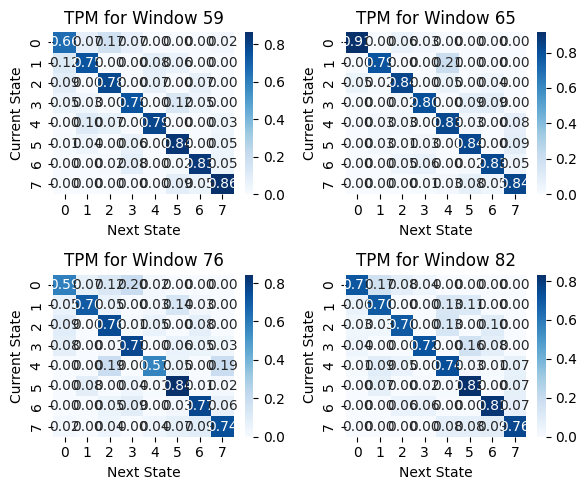

In [6]:
import random
import seaborn as sns

# Select 4 random TPMs from the series
random_tpm_indices = random.sample(range(len(tpm_series)), 4)
selected_tpms = [tpm_series[i] for i in random_tpm_indices]

# Plotting the 4 randomly chosen TPMs
fig, axs = plt.subplots(2, 2, figsize=(6, 5))  # Adjust the size as needed

for i, tpm_index in enumerate(random_tpm_indices):
    ax = axs[i // 2, i % 2]  # Determine the subplot position
    sns.heatmap(selected_tpms[i], annot=True, fmt=".2f", cmap="Blues", ax=ax)
    ax.set_title(f"TPM for Window {tpm_index}")
    ax.set_xlabel("Next State")
    ax.set_ylabel("Current State")

plt.tight_layout()
plt.show()

**Launch PiPhy and compute PHI values**

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-kbn38bdi
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-kbn38bdi
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


2023-12-19 22:55:26,894	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


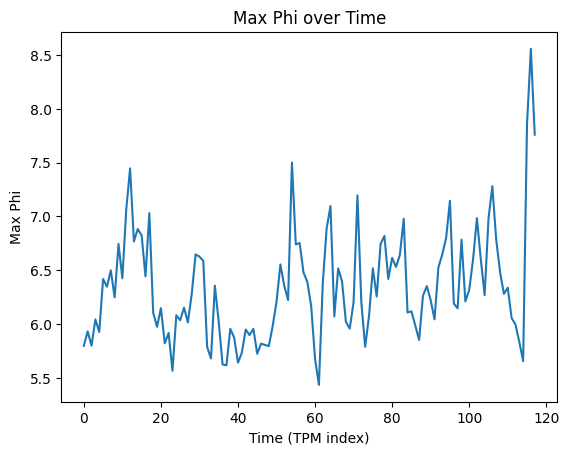

In [8]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Function to calculate phi values and states for a single TPM
def calculate_phi_for_tpm(tpm, possible_states, labels):
    converted_tpm = pyphi.convert.sbs2sbn(tpm)
    network = pyphi.Network(converted_tpm, node_labels=labels)
    node_indices = (0, 1, 2)

    max_phi = -np.inf
    max_phi_state = None

    for state in possible_states:
        candidate_system = pyphi.Subsystem(network, state, node_indices)
        phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
        big_phi = phi_structure.big_phi
        if big_phi > max_phi:
            max_phi = big_phi
            max_phi_state = state

    return max_phi, max_phi_state

# Check if a result file already exists to save time
if not os.path.exists('phi_results_time_series.pkl'):

    labels = ('A', 'B', 'C')
    num_bits = len(labels)
    possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

    tpm_time_series = tpm_series  # List of TPMs

    max_phi_time_series = []
    max_phi_states_time_series = []

    for tpm in tpm_time_series:
        max_phi, max_phi_state = calculate_phi_for_tpm(tpm, possible_states, labels)
        max_phi_time_series.append(max_phi)
        max_phi_states_time_series.append(max_phi_state)

    # Saving the results
    with open('phi_results_time_series.pkl', 'wb') as file:
        pickle.dump((max_phi_time_series, max_phi_states_time_series), file)

else:
    print("File 'phi_results_time_series.pkl' already exists. Skipping computation.")

# Plotting 'max_phi' as a function of time
if max_phi_time_series:
    plt.plot(max_phi_time_series)
    plt.xlabel('Time (TPM index)')
    plt.ylabel('Max Phi')
    plt.title('Max Phi over Time')
    plt.show()